In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt

epochs = 10
lr_sgd = 0.01
lr_adam = 0.0001

In [2]:
class Net(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)  # Return just the mean of the losses

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [5]:
device = torch.device("cuda") # to use the GPU
batch_size = 64

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
      ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)



## Exercise 0
Create a plot of the values of the training/test losses and training accuracies/test.

This can help to monitor how the training is going.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import time

def train_test_plot(model, device, train_loader, test_loader, optimizer, epochs):
    train_loss = []
    test_loss = []
    test_accuracy = []
    epoch_list = []
    epoch_times = []  # Track times for each epoch

    overall_start_time = time.time()  # Start overall timer

    for epoch in range(1, epochs + 1):
        start_time = time.time()  # Start timer for the epoch
        
        epoch_list.append(epoch)
        train_loss.append(train(model, device, train_loader, optimizer, epoch))
        end_time = time.time()  # End timer for the epoch

        
        test_l, accuracy = test(model, device, test_loader)
        test_loss.append(test_l)
        test_accuracy.append(accuracy)  # Track the test accuracy
        
        epoch_times.append(end_time - start_time)  # Record time for the epoch
        
    overall_end_time = time.time()  # End overall timer
    total_execution_time = overall_end_time - overall_start_time  # Calculate total time
    total_training_time = np.sum(epoch_times)  # Total training time
    avg_epoch_time = np.mean(epoch_times)  # Average time per epoch

    # Create a figure with improved layout and size
    plt.figure(figsize=(12, 8))

    # Loss plot
    plt.subplot(2, 1, 1)  # Two rows, one column, first plot
    plt.plot(epoch_list, train_loss, label='Train Loss', color='#1f77b4', linewidth=2, marker='o', markersize=5)
    plt.plot(epoch_list, test_loss, label='Test Loss', color='#ff7f0e', linewidth=2, marker='s', markersize=5)

    plt.title('Training and Testing Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid
    plt.legend(loc='upper right')
    
    # Accuracy plot
    plt.subplot(2, 1, 2)  # Two rows, one column, second plot
    plt.plot(epoch_list, test_accuracy, label='Test Accuracy', color='#2ca02c', linewidth=2, marker='D', markersize=5)
    plt.title('Testing Accuracy Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid
    plt.legend(loc='lower right')

    # Tight layout ensures subplots don't overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print the total and average epoch time with enhanced formatting
    print("="*40)
    print(f" Total Execution Time: {total_execution_time:.2f} seconds")
    print(f" Total Training Time: {total_training_time:.2f} seconds")
    print(f" Average Time per Epoch: {avg_epoch_time:.2f} seconds")
    print("="*40)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302002
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.242766

Test set: Average loss: 0.1926, Accuracy: 9404/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.146592
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.138155

Test set: Average loss: 0.1244, Accuracy: 9635/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.089404
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.178061

Test set: Average loss: 0.0952, Accuracy: 9702/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.021822
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.057403

Test set: Average loss: 0.0826, Accuracy: 9734/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.040781
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.148002

Test set: Average loss: 0.0628, Accuracy: 9795/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.019542
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.149546

Test set: Average loss: 0.0622, Accuracy: 9787/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.029863
Train Epoch: 7 [320

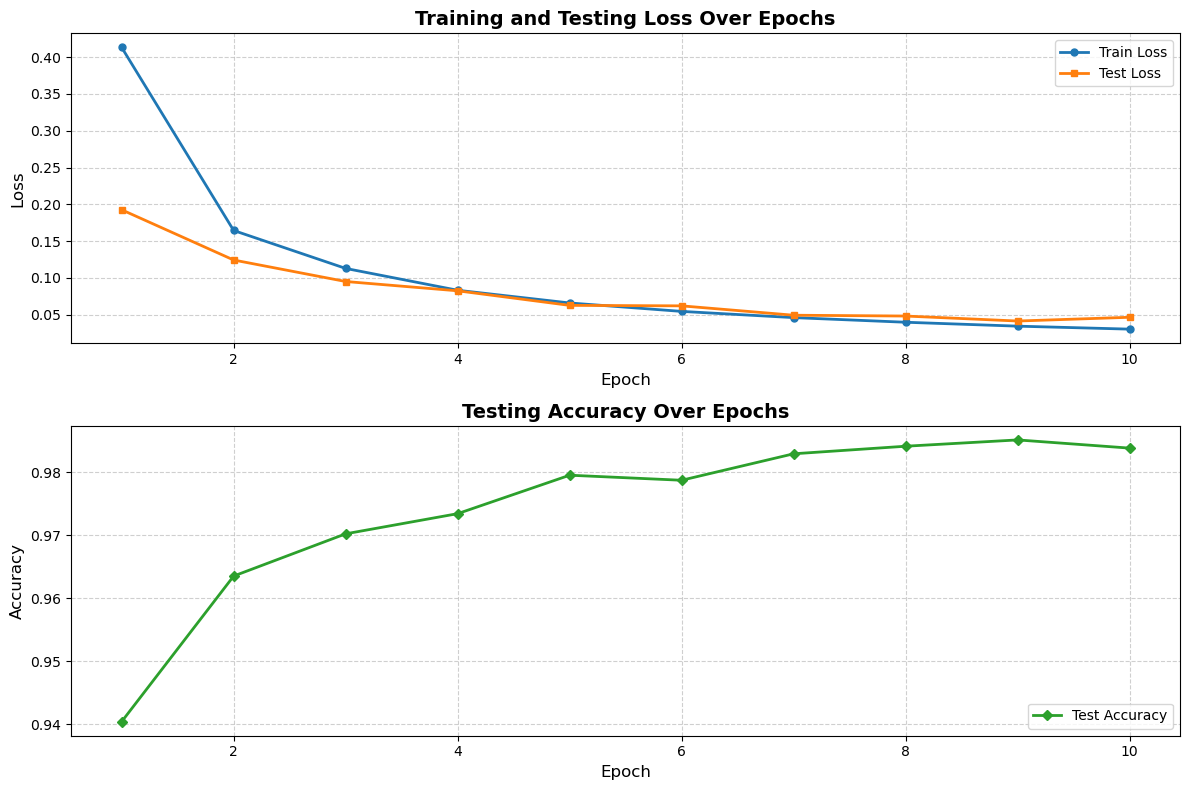

 Total Execution Time: 126.10 seconds
 Total Training Time: 88.86 seconds
 Average Time per Epoch: 8.89 seconds


In [16]:
model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

## Exercise 1

Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding)

How the performance change? Why?

# Fully Connected

I start with a small fully connected with 3 layers

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316062
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.732979

Test set: Average loss: 0.3703, Accuracy: 8956/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.515606
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.265002

Test set: Average loss: 0.2810, Accuracy: 9209/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.344160
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.292921

Test set: Average loss: 0.2453, Accuracy: 9299/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.293660
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.157409

Test set: Average loss: 0.2160, Accuracy: 9375/10000 (94%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.214162
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.334262

Test set: Average loss: 0.1974, Accuracy: 9447/10000 (94%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.240614
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.143001

Test set: Average loss: 0.1775, Accuracy: 9485/10000 (95%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.103206
Train Epoch: 7 [320

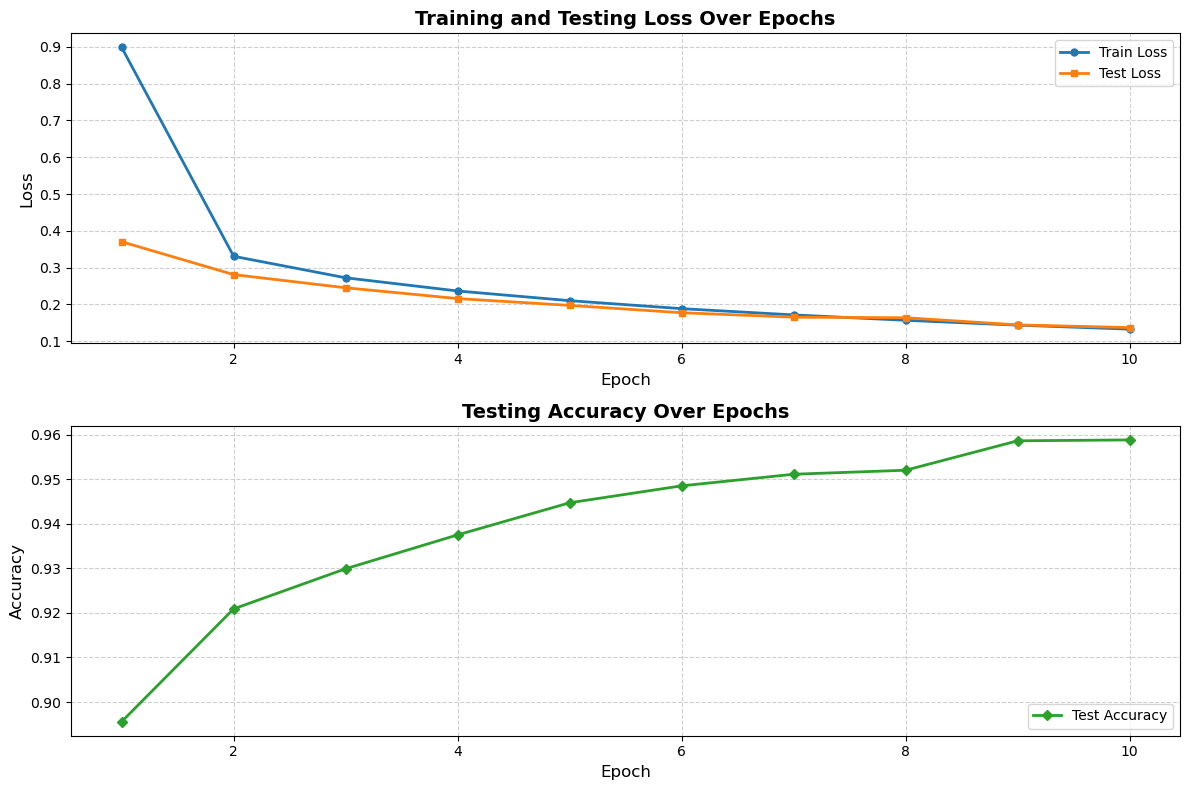

 Total Execution Time: 118.96 seconds
 Total Training Time: 82.78 seconds
 Average Time per Epoch: 8.28 seconds


In [17]:

class SmallFullyConnectedNet(nn.Module):
    def __init__(self):
        super(SmallFullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(784, 64)  # First layer: Input 784, output 64
        self.fc2 = nn.Linear(64, 32)   # Second layer: Input 64, output 32
        self.fc3 = nn.Linear(32, 10)   # Third layer: Input 32, output 10 (classes)
        
    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the input from (B, 1, 28, 28) to (B, 784)
        x = F.relu(self.fc1(x))  # Apply ReLU after first layer
        x = F.relu(self.fc2(x))  # Apply ReLU after second layer
        x = self.fc3(x)          # Output layer, no activation function (we'll use softmax outside)
        return F.log_softmax(x, dim=1)  # Use log_softmax for classification


model = SmallFullyConnectedNet().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.373329
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.587254

Test set: Average loss: 0.2857, Accuracy: 9405/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.326375
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.326567

Test set: Average loss: 0.1748, Accuracy: 9587/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.246829
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.080760

Test set: Average loss: 0.1362, Accuracy: 9637/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.122624
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.356055

Test set: Average loss: 0.1177, Accuracy: 9685/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.177508
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.083744

Test set: Average loss: 0.1045, Accuracy: 9719/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.112164
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.042950

Test set: Average loss: 0.0956, Accuracy: 9745/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.113395
Train Epoch: 7 [320

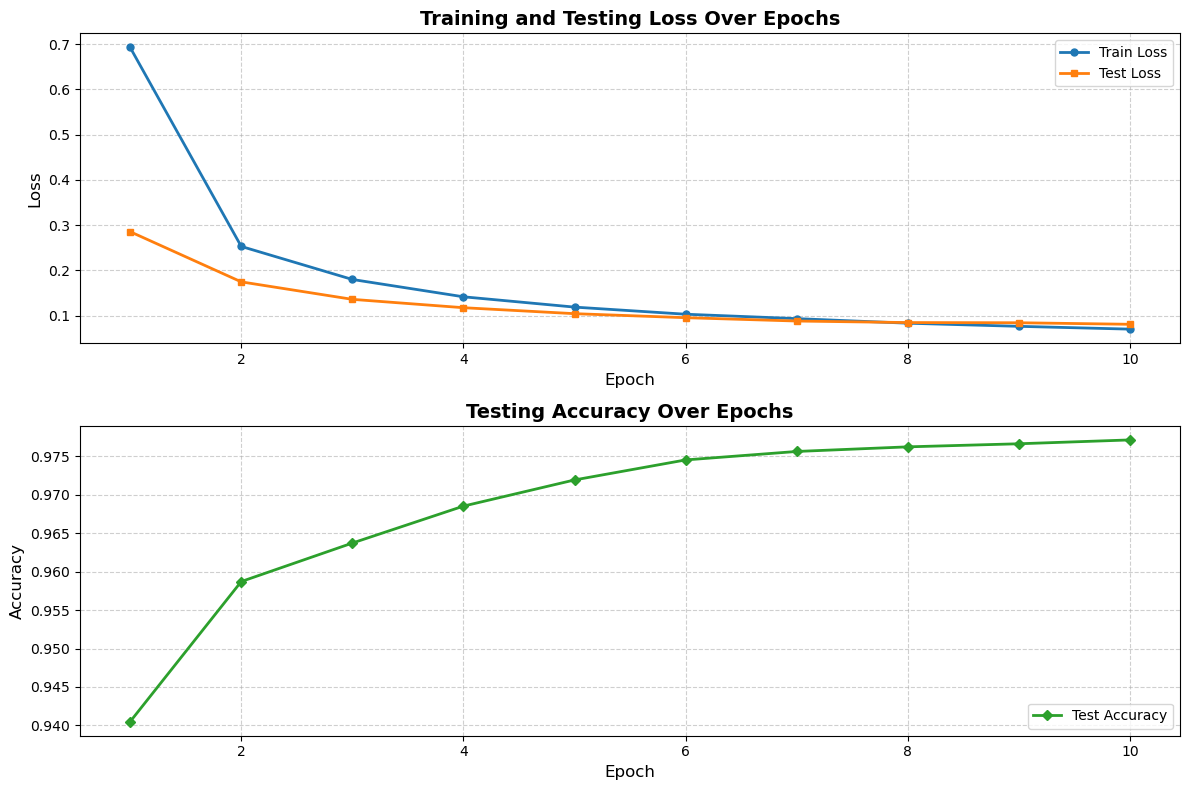

 Total Execution Time: 123.23 seconds
 Total Training Time: 86.15 seconds
 Average Time per Epoch: 8.62 seconds


In [18]:
class Small_Linear_Normalized(nn.Module):
    def __init__(self):
        super(Small_Linear_Normalized, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(784, 64)  # First layer: Input 784, output 64
        self.bn1 = nn.BatchNorm1d(64)  # Batch normalization for the first layer
        
        self.fc2 = nn.Linear(64, 32)   # Second layer: Input 64, output 32
        self.bn2 = nn.BatchNorm1d(32)  # Batch normalization for the second layer
        
        self.fc3 = nn.Linear(32, 10)   # Third layer: Input 32, output 10 (classes)

    def forward(self, x):
        x = torch.flatten(x, 1)        # Flatten the input from (B, 1, 28, 28) to (B, 784)
        
        # First layer with batch normalization and ReLU activation
        x = self.fc1(x)
        x = self.bn1(x)                # Apply batch normalization
        x = F.relu(x)                  # Apply ReLU
        
        # Second layer with batch normalization and ReLU activation
        x = self.fc2(x)
        x = self.bn2(x)                # Apply batch normalization
        x = F.relu(x)                  # Apply ReLU
        
        # Output layer without batch normalization
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1) # Use log_softmax for classification

# Initialize model, optimizer, and run training and testing
model = Small_Linear_Normalized().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)


CNN scores are a little better that Fully Connected even time of execution.

In general a CNN works better because a fully connected does not focus on local features of the image.

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309155
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.443256

Test set: Average loss: 0.3593, Accuracy: 8943/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.351057
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.215578

Test set: Average loss: 0.2545, Accuracy: 9246/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.197892
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.264802

Test set: Average loss: 0.2131, Accuracy: 9385/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.100595
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.211464

Test set: Average loss: 0.1783, Accuracy: 9494/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.122230
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.212965

Test set: Average loss: 0.1513, Accuracy: 9540/10000 (95%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.087601
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.129702

Test set: Average loss: 0.1334, Accuracy: 9591/10000 (96%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.141159
Train Epoch: 7 [320

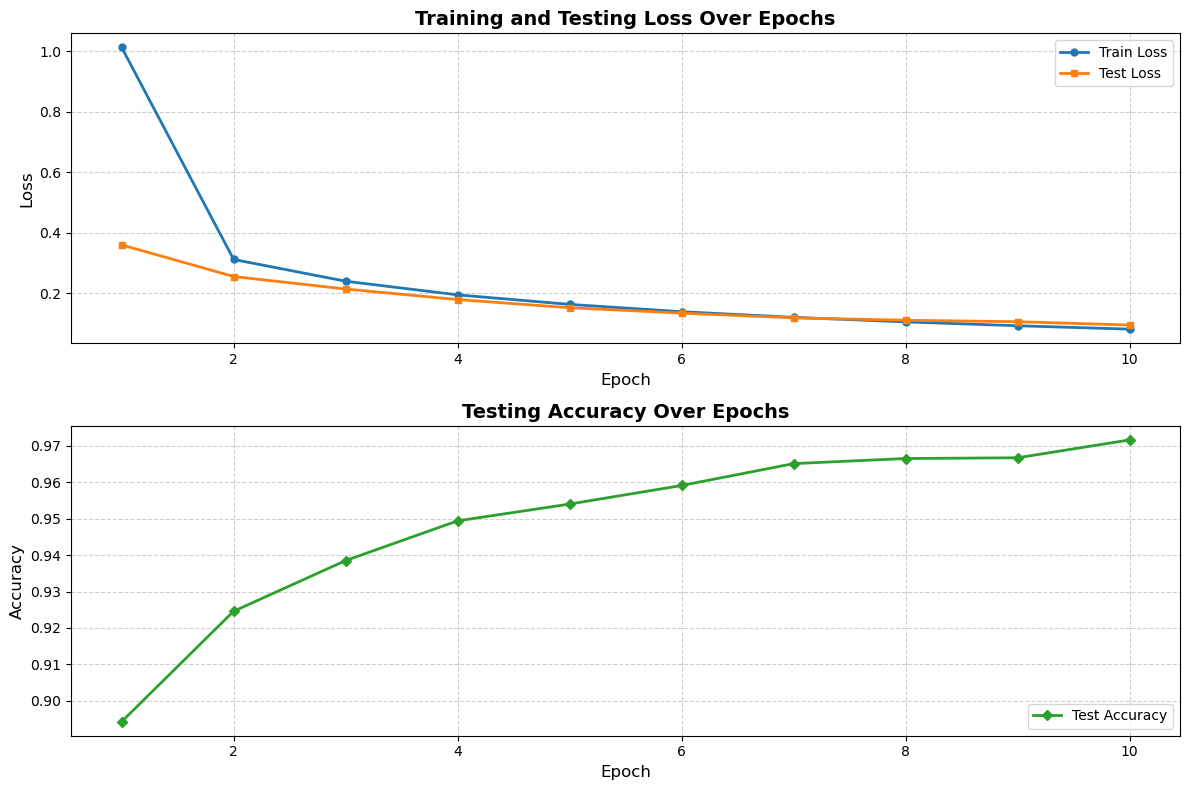

 Total Execution Time: 121.75 seconds
 Total Training Time: 84.94 seconds
 Average Time per Epoch: 8.49 seconds


In [19]:
class Net_Larger_FC(nn.Module):
    def __init__(self):
        super(Net_Larger_FC, self).__init__()
        
        # Increase the size of the hidden layers
        self.fc1 = nn.Linear(784, 1024)  # First layer with 1024 neurons
        self.fc2 = nn.Linear(1024, 512)    # Second layer with 512 neurons
        self.fc3 = nn.Linear(512, 256)     # Third layer with 256 neurons
        self.fc4 = nn.Linear(256, 10)      # Output layer with 10 neurons for 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the image to a 1D vector
        
        # Pass through fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # Output layer with log_softmax activation for classification
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    
model = Net_Larger_FC().to(device)

optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.465470
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.219750

Test set: Average loss: 0.1334, Accuracy: 9628/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.156928
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.090727

Test set: Average loss: 0.0923, Accuracy: 9729/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.053947
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.070414

Test set: Average loss: 0.0776, Accuracy: 9780/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.010469
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.031287

Test set: Average loss: 0.0664, Accuracy: 9790/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.115828
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.049895

Test set: Average loss: 0.0642, Accuracy: 9798/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.020717
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.054809

Test set: Average loss: 0.0596, Accuracy: 9805/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.014982
Train Epoch: 7 [320

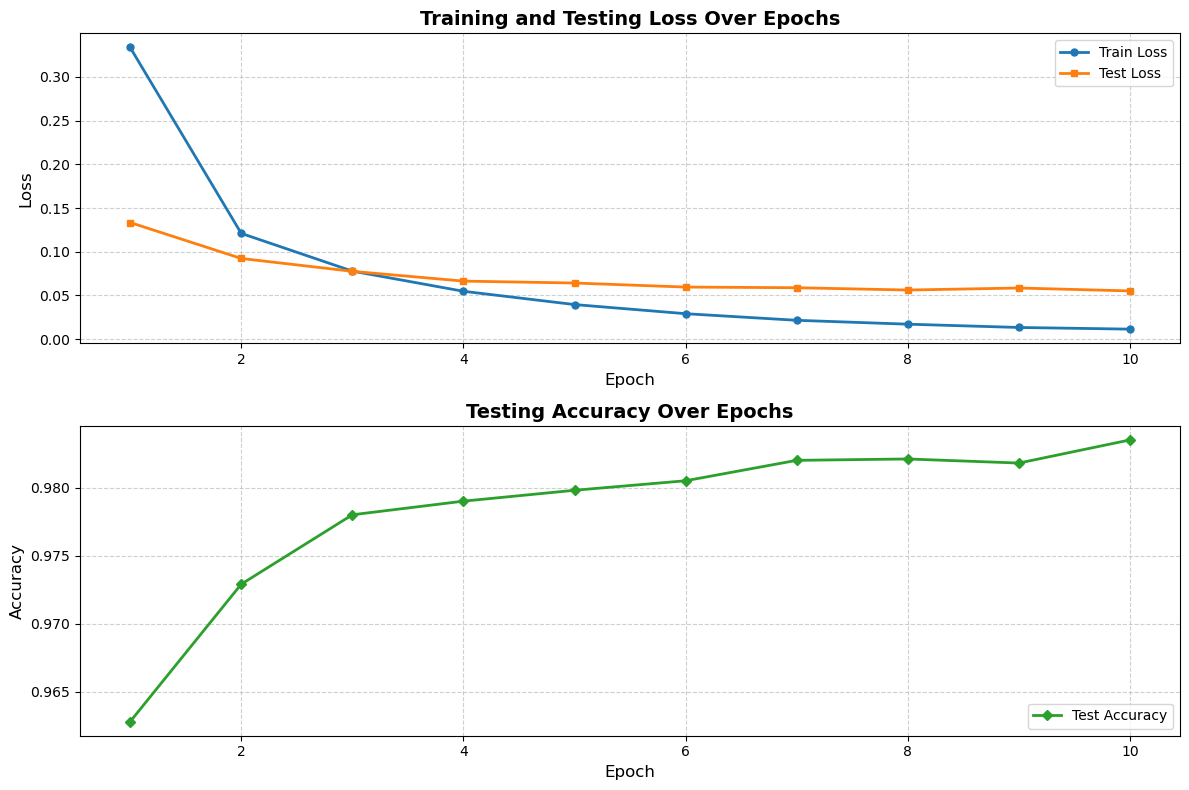

 Total Execution Time: 120.72 seconds
 Total Training Time: 83.68 seconds
 Average Time per Epoch: 8.37 seconds


In [20]:
class Net_Larger_FC_Normalized(nn.Module):
    def __init__(self):
        super(Net_Larger_FC_Normalized, self).__init__()
        
        # Increase the size of the hidden layers
        self.fc1 = nn.Linear(784, 1024)    # First layer with 1024 neurons
        self.bn1 = nn.BatchNorm1d(1024)    # Batch normalization for the first layer
        
        self.fc2 = nn.Linear(1024, 512)    # Second layer with 512 neurons
        self.bn2 = nn.BatchNorm1d(512)     # Batch normalization for the second layer
        
        self.fc3 = nn.Linear(512, 256)     # Third layer with 256 neurons
        self.bn3 = nn.BatchNorm1d(256)     # Batch normalization for the third layer
        
        self.fc4 = nn.Linear(256, 10)      # Output layer with 10 neurons for 10 classes

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten the image to a 1D vector
        
        # Pass through fully connected layers with batch normalization and ReLU activation
        x = F.relu(self.bn1(self.fc1(x)))  # First layer + batch norm + ReLU
        x = F.relu(self.bn2(self.fc2(x)))  # Second layer + batch norm + ReLU
        x = F.relu(self.bn3(self.fc3(x)))  # Third layer + batch norm + ReLU
        
        # Output layer with log_softmax activation for classification
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    
# Initialize model, optimizer, and run training and testing
model = Net_Larger_FC_Normalized().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)


Now i create a depper version with similar number of parameters. The large one has 1,462,538 parameters, this deeper one has 1,446,082 so not exactly the same but we have a similar number

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.275117
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.297824

Test set: Average loss: 0.1780, Accuracy: 9625/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.180343
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.206272

Test set: Average loss: 0.1133, Accuracy: 9728/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.132330
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.075776

Test set: Average loss: 0.0904, Accuracy: 9761/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.027221
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.023978

Test set: Average loss: 0.0805, Accuracy: 9777/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.023708
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.043163

Test set: Average loss: 0.0847, Accuracy: 9762/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.009143
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.024367

Test set: Average loss: 0.0755, Accuracy: 9797/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.020761
Train Epoch: 7 [320

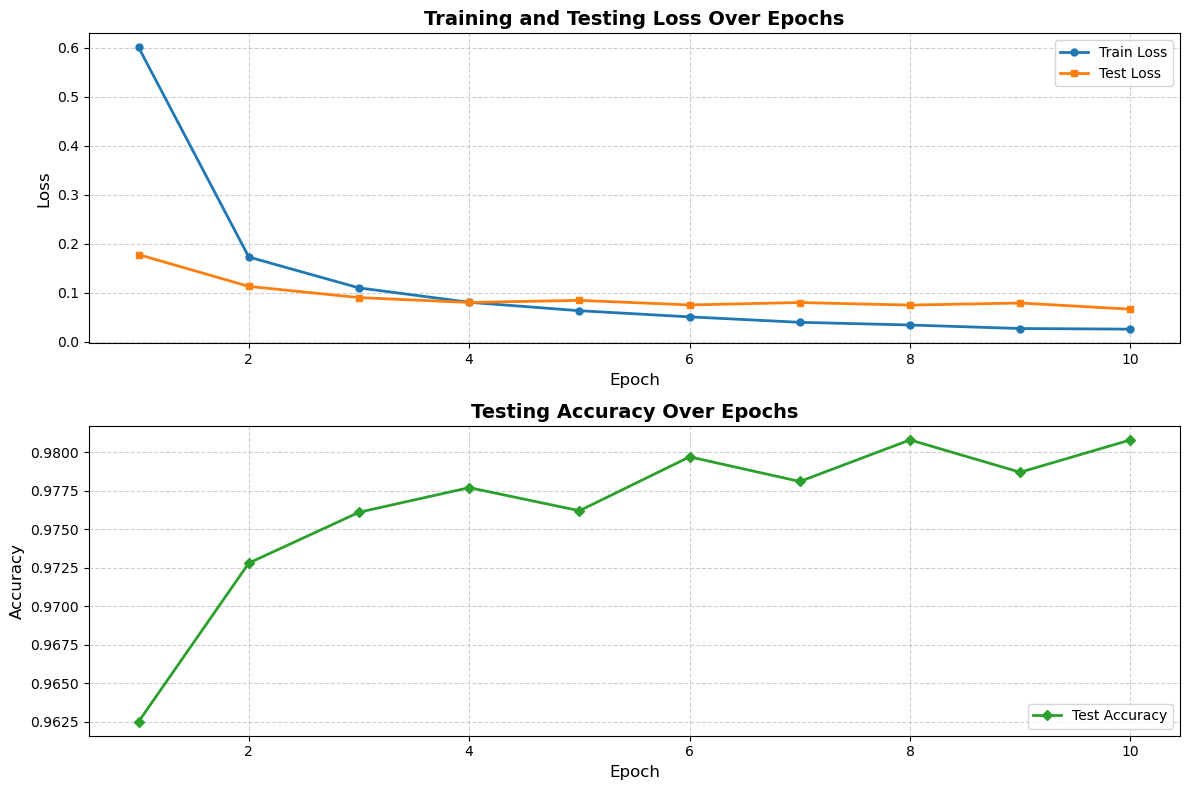

 Total Execution Time: 126.52 seconds
 Total Training Time: 89.69 seconds
 Average Time per Epoch: 8.97 seconds


In [21]:
class Net_Deeper(nn.Module):
    def __init__(self):
        super(Net_Deeper, self).__init__()
        
        # Architecture with 11 layers and batch normalization
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for fc1
        
        self.fc2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)  # Batch normalization for fc2
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(512)  # Batch normalization for fc3
        
        self.fc4 = nn.Linear(512, 512)
        self.bn4 = nn.BatchNorm1d(512)  # Batch normalization for fc4
        
        self.fc5 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)  # Batch normalization for fc5
        
        self.fc6 = nn.Linear(256, 512)
        self.bn6 = nn.BatchNorm1d(512)  # Batch normalization for fc6
        
        self.fc7 = nn.Linear(512, 128)
        self.bn7 = nn.BatchNorm1d(128)  # Batch normalization for fc7
        
        self.fc8 = nn.Linear(128, 128)
        self.bn8 = nn.BatchNorm1d(128)  # Batch normalization for fc8
        
        self.fc9 = nn.Linear(128, 64)
        self.bn9 = nn.BatchNorm1d(64)   # Batch normalization for fc9
        
        self.fc10 = nn.Linear(64, 32)
        self.bn10 = nn.BatchNorm1d(32)  # Batch normalization for fc10
        
        self.fc11 = nn.Linear(32, 10)   # Output layer

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        # Passing through fully connected layers with batch normalization and ReLU
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = F.relu(self.bn8(self.fc8(x)))
        x = F.relu(self.bn9(self.fc9(x)))
        x = F.relu(self.bn10(self.fc10(x)))
        
        # Output layer with log_softmax for classification
        x = F.log_softmax(self.fc11(x), dim=1)
        return x
    
# Initialize model, optimizer, and run training and testing
model = Net_Deeper().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.392344
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.236897

Test set: Average loss: 0.1099, Accuracy: 9750/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.115060
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.093431

Test set: Average loss: 0.0840, Accuracy: 9776/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.057008
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.180948

Test set: Average loss: 0.0722, Accuracy: 9801/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.021866
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.057835

Test set: Average loss: 0.0662, Accuracy: 9810/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.014730
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.025605

Test set: Average loss: 0.0699, Accuracy: 9795/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.021256
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.006071

Test set: Average loss: 0.0813, Accuracy: 9759/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.053672
Train Epoch: 7 [320

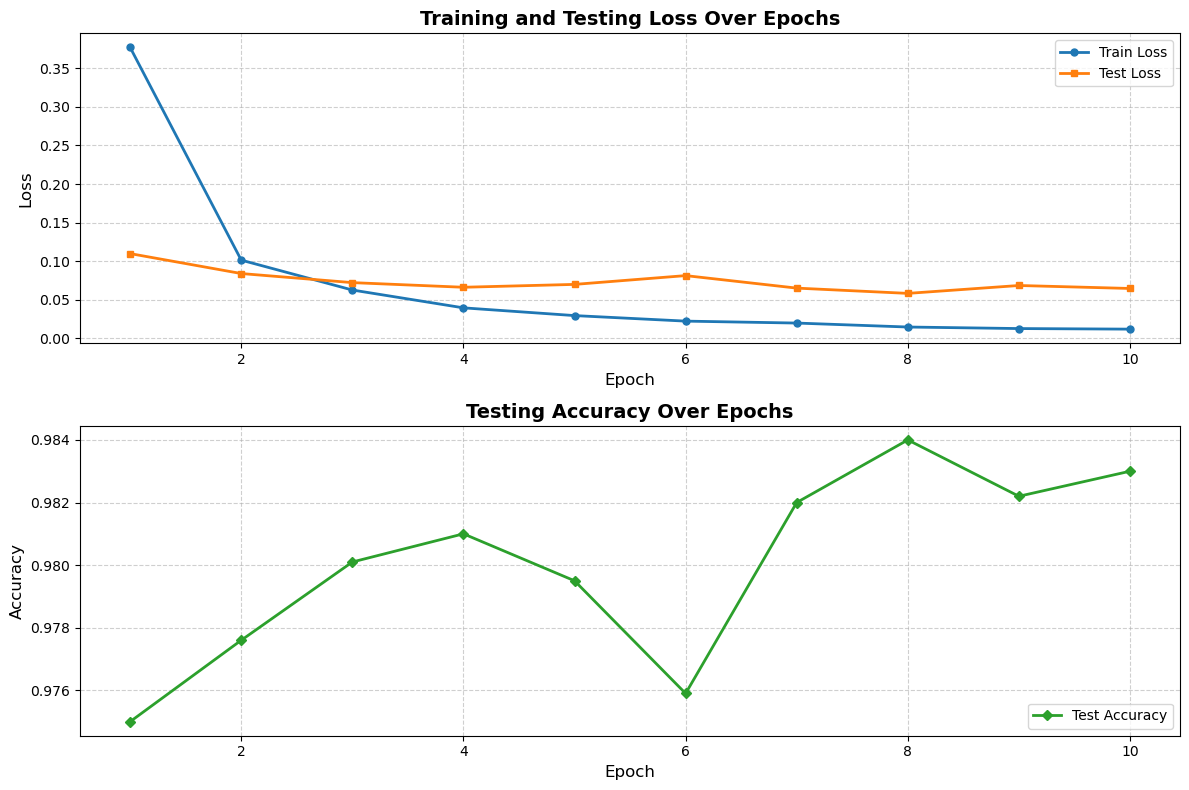

 Total Execution Time: 124.80 seconds
 Total Training Time: 88.30 seconds
 Average Time per Epoch: 8.83 seconds


In [22]:
class Net_Deeper_Large(nn.Module):
    def __init__(self):
        super(Net_Deeper_Large, self).__init__()
        
        # Increase the sizes of each layer significantly
        self.fc1 = nn.Linear(28*28, 2048)
        self.bn1 = nn.BatchNorm1d(2048)  # Batch normalization layer
        
        self.fc2 = nn.Linear(2048, 2048)
        self.bn2 = nn.BatchNorm1d(2048)  # Batch normalization layer
        
        self.fc3 = nn.Linear(2048, 2048)
        self.bn3 = nn.BatchNorm1d(2048)  # Batch normalization layer
        
        self.fc4 = nn.Linear(2048, 1024)
        self.bn4 = nn.BatchNorm1d(1024)  # Batch normalization layer
        
        self.fc5 = nn.Linear(1024, 1024)
        self.bn5 = nn.BatchNorm1d(1024)  # Batch normalization layer
        
        self.fc6 = nn.Linear(1024, 512)
        self.bn6 = nn.BatchNorm1d(512)  # Batch normalization layer
        
        self.fc7 = nn.Linear(512, 512)
        self.bn7 = nn.BatchNorm1d(512)  # Batch normalization layer
        
        self.fc8 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)  # Batch normalization layer
        
        self.fc9 = nn.Linear(256, 128)
        self.bn9 = nn.BatchNorm1d(128)  # Batch normalization layer
        
        self.fc10 = nn.Linear(128, 64)
        self.bn10 = nn.BatchNorm1d(64)  # Batch normalization layer
        
        self.fc11 = nn.Linear(64, 10)  # Output layer (no batch norm)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = F.relu(self.bn8(self.fc8(x)))
        x = F.relu(self.bn9(self.fc9(x)))
        x = F.relu(self.bn10(self.fc10(x)))
        x = F.log_softmax(self.fc11(x), dim=1)
        return x

    
model = Net_Deeper_Large().to(device)

optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Here the number of parameters increased a lot and clearly i would say that the performances are better with a little slower time execution

# CNN with avg and maxpoolimg

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.287894
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.241996

Test set: Average loss: 0.2852, Accuracy: 9174/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.205603
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.314257

Test set: Average loss: 0.1863, Accuracy: 9457/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.243385
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.156428

Test set: Average loss: 0.1448, Accuracy: 9566/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.116513
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.156226

Test set: Average loss: 0.1346, Accuracy: 9598/10000 (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.042441
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.098818

Test set: Average loss: 0.1108, Accuracy: 9658/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.134921
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.012998

Test set: Average loss: 0.0945, Accuracy: 9710/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.069708
Train Epoch: 7 [320

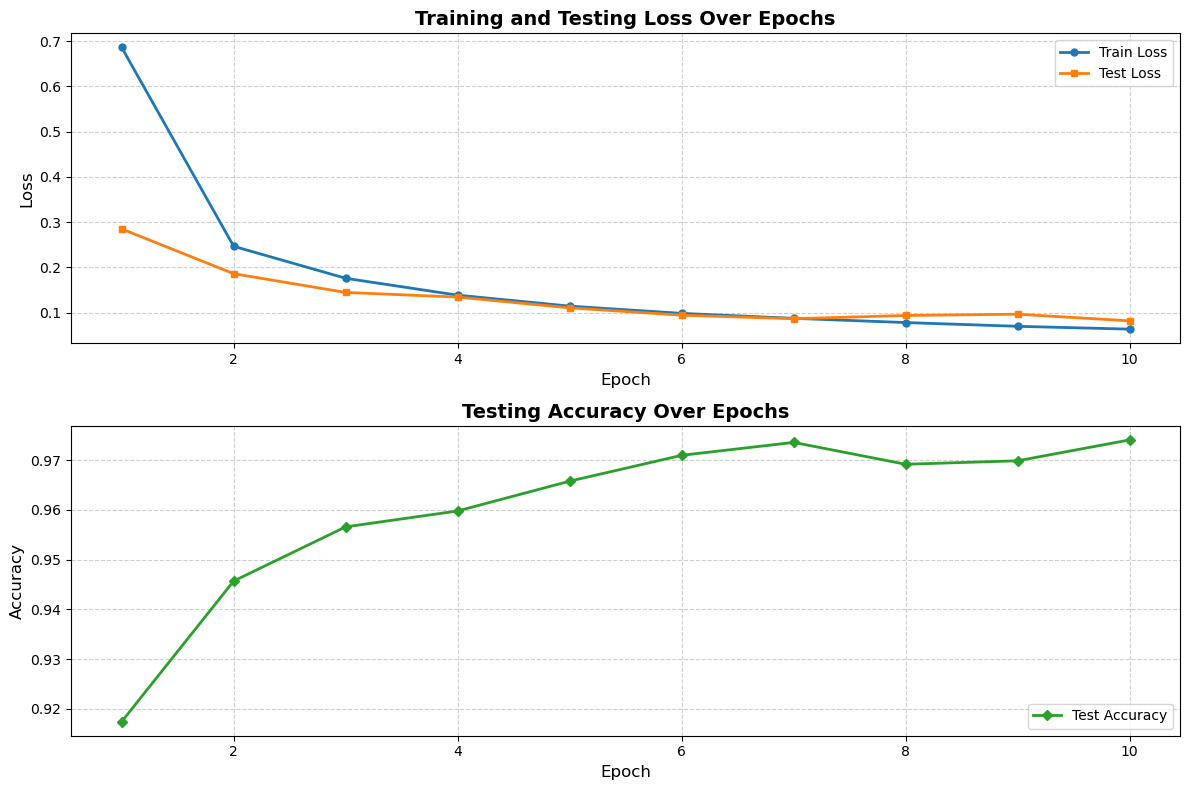

 Total Execution Time: 125.67 seconds
 Total Training Time: 88.02 seconds
 Average Time per Epoch: 8.80 seconds


In [23]:
class Net_With_Stride(nn.Module):
    def __init__(self):
        super(Net_With_Stride, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2)  # Stride of 1
        self.conv2 = nn.Conv2d(32, 64, 3, 2)  # Stride of 1
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution layer 1 with stride 1
        x = self.conv1(x)
        x = F.relu(x)
        
        # Convolution layer 2 with stride 1
        x = self.conv2(x)
        x = F.relu(x)
        
        # Max pooling with kernel size 2
        
        # Flattening and fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Log-softmax for classification output
        output = F.log_softmax(x, dim=1)
        return output


model = Net_With_Stride().to(device)


optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315347
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.332358

Test set: Average loss: 0.2145, Accuracy: 9360/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.215820
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.244773

Test set: Average loss: 0.1475, Accuracy: 9552/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.137582
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.063607

Test set: Average loss: 0.1178, Accuracy: 9619/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.206354
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.035101

Test set: Average loss: 0.0999, Accuracy: 9683/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.171174
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.130013

Test set: Average loss: 0.1036, Accuracy: 9685/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.144357
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.040975

Test set: Average loss: 0.0942, Accuracy: 9707/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.049358
Train Epoch: 7 [320

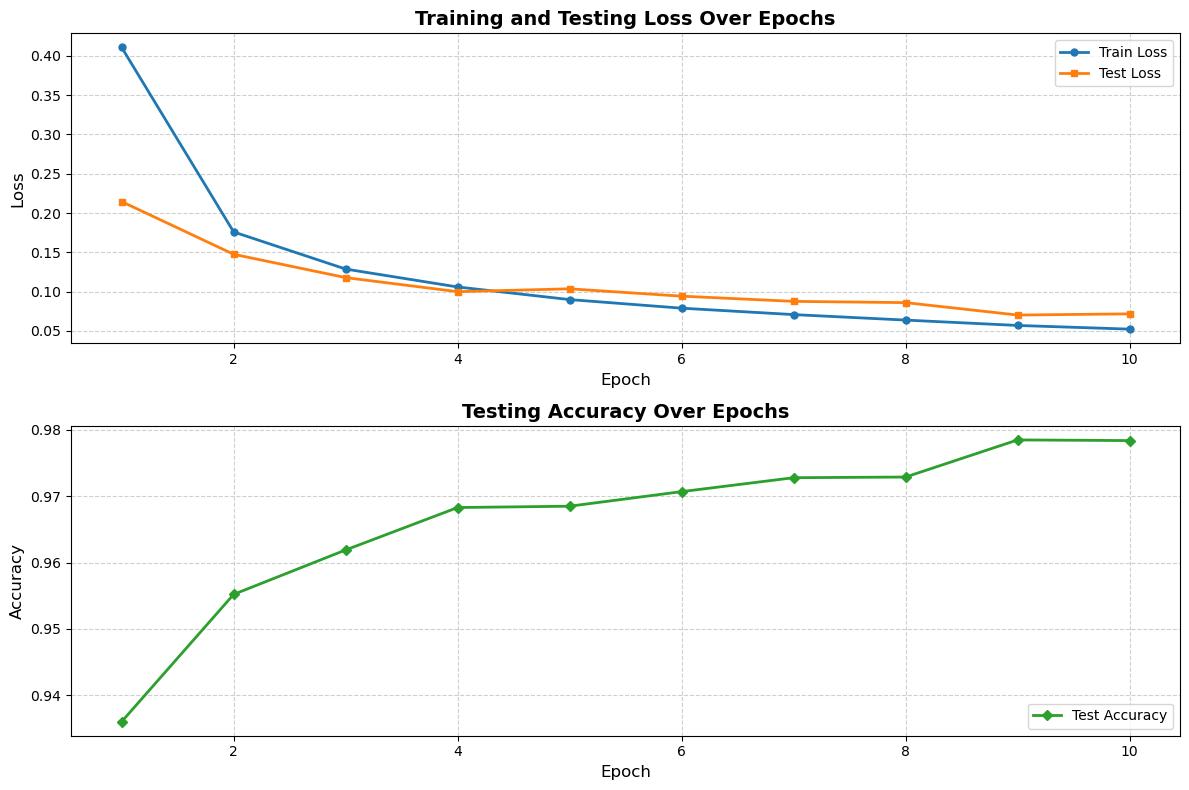

 Total Execution Time: 127.63 seconds
 Total Training Time: 90.45 seconds
 Average Time per Epoch: 9.04 seconds


In [24]:
class Net_With_AvgPooling(nn.Module):
    def __init__(self):
        super(Net_With_AvgPooling, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # Stride of 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # Stride of 1
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution layer 1 with stride 1
        x = self.conv1(x)
        x = F.relu(x)
        
        # Convolution layer 2 with stride 1
        x = self.conv2(x)
        x = F.relu(x)
        
        # Avg pooling with kernel size 2
        x = F.avg_pool2d(x, 2)
        
        # Flattening and fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Log-softmax for classification output
        output = F.log_softmax(x, dim=1)
        return output

model = Net_With_AvgPooling().to(device)


optimizer = optim.SGD(model.parameters(), lr_sgd)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320545
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.231479

Test set: Average loss: 0.1588, Accuracy: 9543/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.198153
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.071013

Test set: Average loss: 0.0863, Accuracy: 9731/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.068552
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.047526

Test set: Average loss: 0.0609, Accuracy: 9800/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.033517
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.064667

Test set: Average loss: 0.0549, Accuracy: 9831/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.055360
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.010737

Test set: Average loss: 0.0473, Accuracy: 9855/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.052261
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.167271

Test set: Average loss: 0.0402, Accuracy: 9874/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.018439
Train Epoch: 7 [320

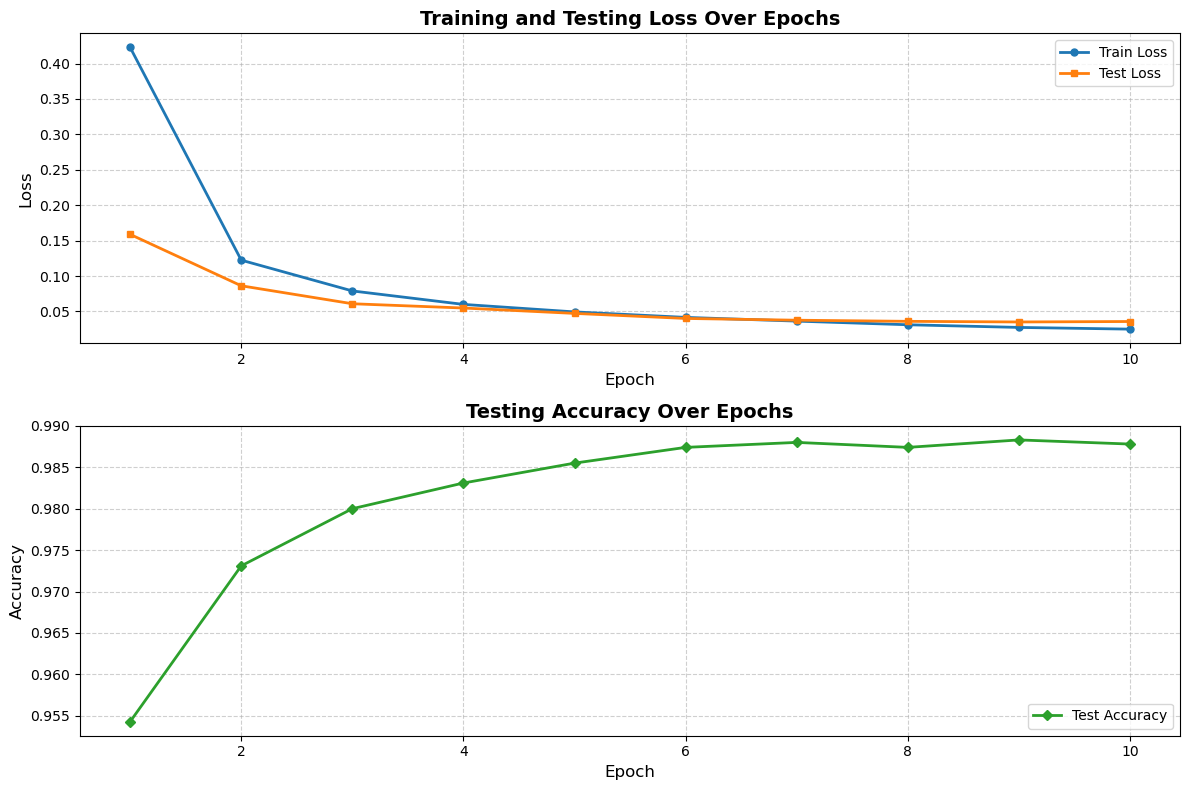

 Total Execution Time: 263.46 seconds
 Total Training Time: 196.79 seconds
 Average Time per Epoch: 19.68 seconds


In [8]:
class Net_bigger_kernels(nn.Module):
    def __init__(self):
        """ 
        from torch.docs
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                        groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net_bigger_kernels, self).__init__()
        
        # Increased kernel size from 3x3 to 5x5
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6400, 128)  # Adjusted input size due to larger kernels
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, C, H, W
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        # Max pooling layer
        x = F.max_pool2d(x, 2)
        
        # Flatten the feature maps into a vector
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Output with log_softmax for classification
        output = F.log_softmax(x, dim=1)
        return output

# Initialize the model and optimizer
model = Net_bigger_kernels().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)

# Run training and testing
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)


In [1]:
class Net(nn.Module):
    def __init__(self):
        """ 
        from torch.docs
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                        groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net, self).__init__()
        
        # Increased kernel size from 3x3 to 5x5
        self.conv1 = nn.Conv2d(1, 32, kernel_size=9, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7, stride=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6400, 128)  # Adjusted input size due to larger kernels
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, C, H, W
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        # Max pooling layer
        x = F.max_pool2d(x, 2)
        
        # Flatten the feature maps into a vector
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Output with log_softmax for classification
        output = F.log_softmax(x, dim=1)
        return output

# Initialize the model and optimizer
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)

# Run training and testing
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)


NameError: name 'nn' is not defined

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296996
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.136853

Test set: Average loss: 0.2225, Accuracy: 9223/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.432610
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.181251

Test set: Average loss: 0.0834, Accuracy: 9733/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022752
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.069698

Test set: Average loss: 0.0610, Accuracy: 9809/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.284716
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.018402

Test set: Average loss: 0.0582, Accuracy: 9806/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.028731
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.026594

Test set: Average loss: 0.0399, Accuracy: 9871/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.083931
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.022587

Test set: Average loss: 0.0360, Accuracy: 9876/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.005365
Train Epoch: 7 [320

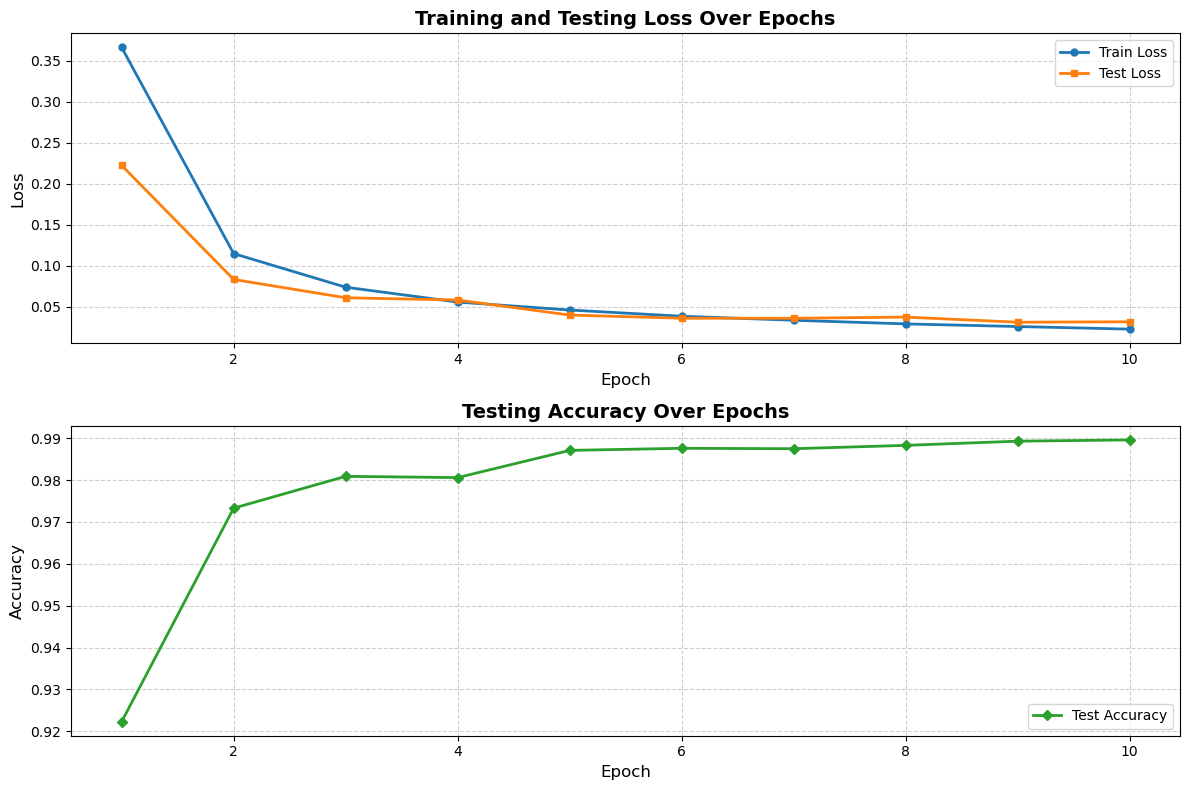

 Total Execution Time: 626.31 seconds
 Total Training Time: 547.78 seconds
 Average Time per Epoch: 54.78 seconds


In [12]:
class Net_padding(nn.Module):
    def __init__(self):
        """ 
        from torch.docs
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                        groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net_padding, self).__init__()
        
        # Increased kernel size from 3x3 to 5x5
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2, padding_mode='reflect')
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2, padding_mode='reflect')
        
        # Fully connected layers
        self.fc1 = nn.Linear(12544, 128)  # Adjusted input size due to larger kernels
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, C, H, W
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        # Max pooling layer
        x = F.max_pool2d(x, 2)
        
        # Flatten the feature maps into a vector
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        # Output with log_softmax for classification
        output = F.log_softmax(x, dim=1)
        return output

# Initialize the model and optimizer
model = Net_padding().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)

# Run training and testing
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321799
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.492604

Test set: Average loss: 0.2369, Accuracy: 9320/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.196795
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.176558

Test set: Average loss: 0.1208, Accuracy: 9636/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.073629
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.062833

Test set: Average loss: 0.1027, Accuracy: 9688/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.052803
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.035732

Test set: Average loss: 0.0675, Accuracy: 9794/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.184497
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.054051

Test set: Average loss: 0.0632, Accuracy: 9803/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.049115
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.037402

Test set: Average loss: 0.0594, Accuracy: 9791/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.068553
Train Epoch: 7 [320

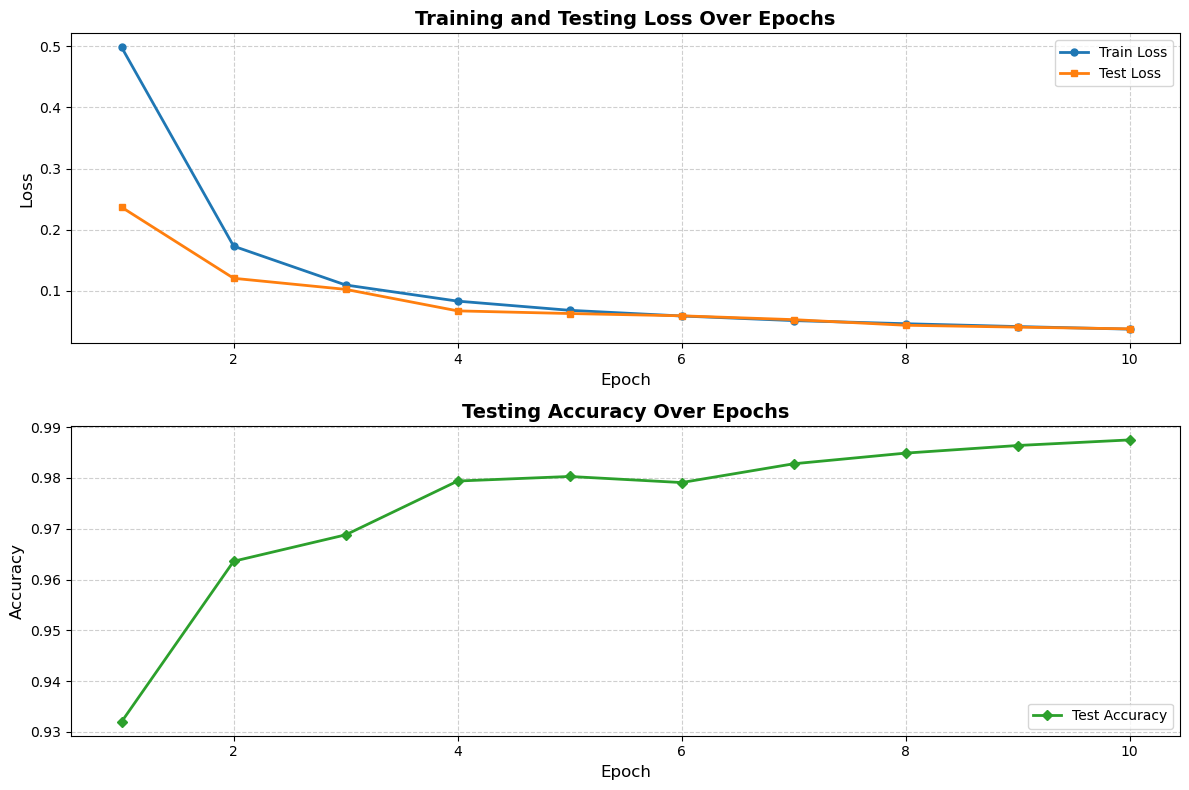

 Total Execution Time: 256.49 seconds
 Total Training Time: 196.46 seconds
 Average Time per Epoch: 19.65 seconds


In [10]:
class Net_dilated(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                            groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        """
        super(Net_dilated, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1,dilation=2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1,dilation=2)
        self.fc1 = nn.Linear(6400, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x.shape B, N, H, W
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    
# Initialize the model and optimizer
model = Net_dilated().to(device)
optimizer = optim.SGD(model.parameters(), lr_sgd)

# Run training and testing
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)



## Exercise 2

Try to work with the hyperparameters (batch_size, learning_rate, ...).

In particular try to focus on the optimization part. Change algorithm, momentum, parameters...

Please refer to https://pytorch.org/docs/stable/optim.html to see how to set all the parameters

How can it be improved?

Here the

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299347
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.095396

Test set: Average loss: 0.0484, Accuracy: 9843/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.047263
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.035219

Test set: Average loss: 0.0406, Accuracy: 9851/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.003938
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000316

Test set: Average loss: 0.0279, Accuracy: 9899/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.002745
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.001247

Test set: Average loss: 0.0258, Accuracy: 9911/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.001626
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.024245

Test set: Average loss: 0.0285, Accuracy: 9899/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000353
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.010795

Test set: Average loss: 0.0280, Accuracy: 9904/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.001388
Train Epoch: 7 [320

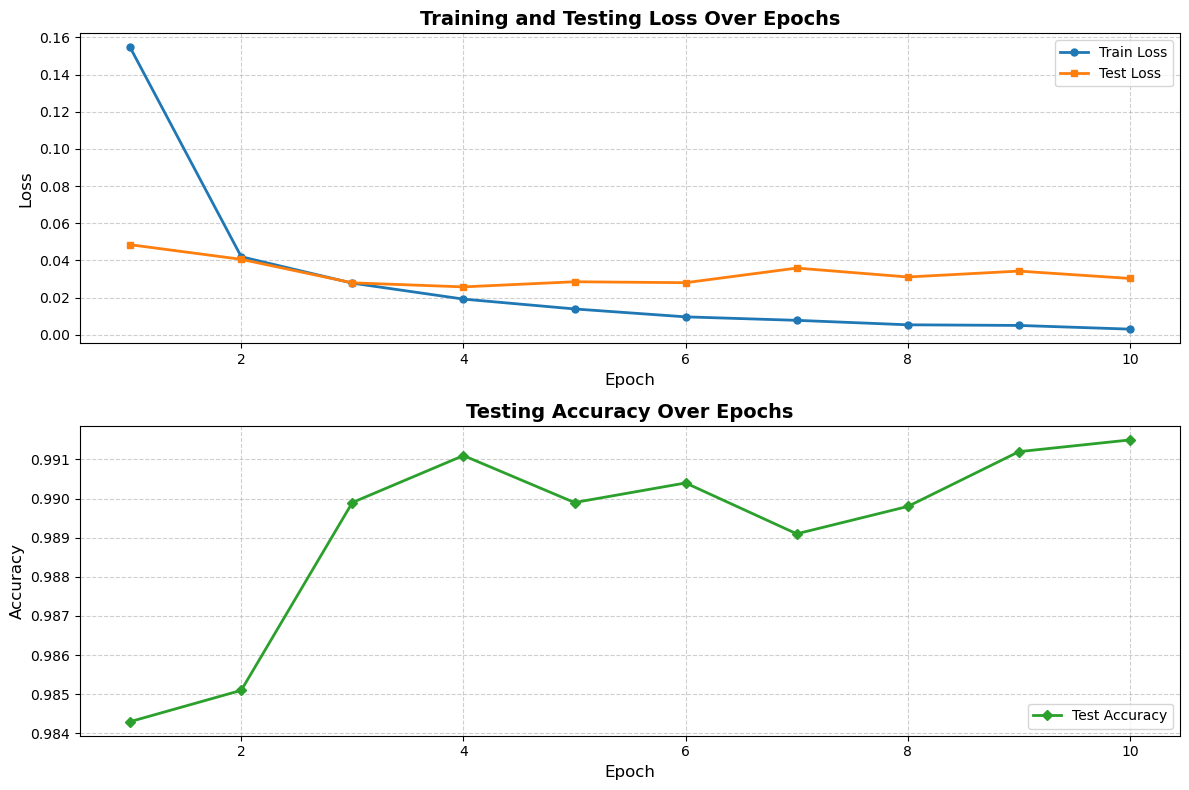

 Total Execution Time: 114.89 seconds
 Total Training Time: 80.53 seconds
 Average Time per Epoch: 8.05 seconds


In [17]:
model = Net().to(device)    

optimizer = optim.SGD(model.parameters(), 0.1)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318378
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.256463

Test set: Average loss: 2.2201, Accuracy: 4410/10000 (44%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.227026
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.147479

Test set: Average loss: 2.0927, Accuracy: 6301/10000 (63%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.096015
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.027507

Test set: Average loss: 1.8662, Accuracy: 6980/10000 (70%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.903191
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.626104

Test set: Average loss: 1.4943, Accuracy: 7506/10000 (75%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.451112
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.283243

Test set: Average loss: 1.0655, Accuracy: 8074/10000 (81%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.040589
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.811011

Test set: Average loss: 0.7699, Accuracy: 8411/10000 (84%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.798126
Train Epoch: 7 [320

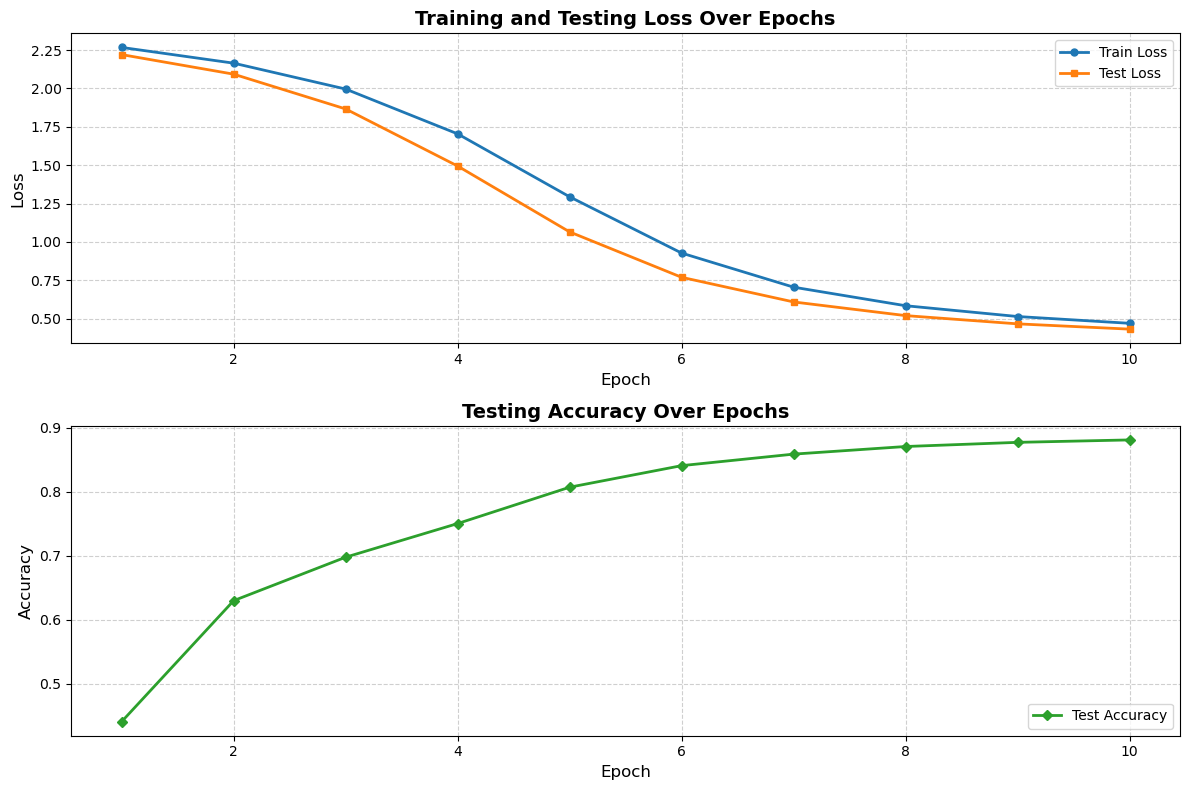

 Total Execution Time: 114.70 seconds
 Total Training Time: 80.16 seconds
 Average Time per Epoch: 8.02 seconds


In [18]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.0001)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

# With momentum

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300771
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.052951

Test set: Average loss: 0.0490, Accuracy: 9826/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.077928
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.006994

Test set: Average loss: 0.0333, Accuracy: 9896/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.016524
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.033699

Test set: Average loss: 0.0279, Accuracy: 9903/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.028053
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.010538

Test set: Average loss: 0.0263, Accuracy: 9908/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.003295
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.001065

Test set: Average loss: 0.0350, Accuracy: 9892/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.004996
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.049271

Test set: Average loss: 0.0334, Accuracy: 9895/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.003275
Train Epoch: 7 [320

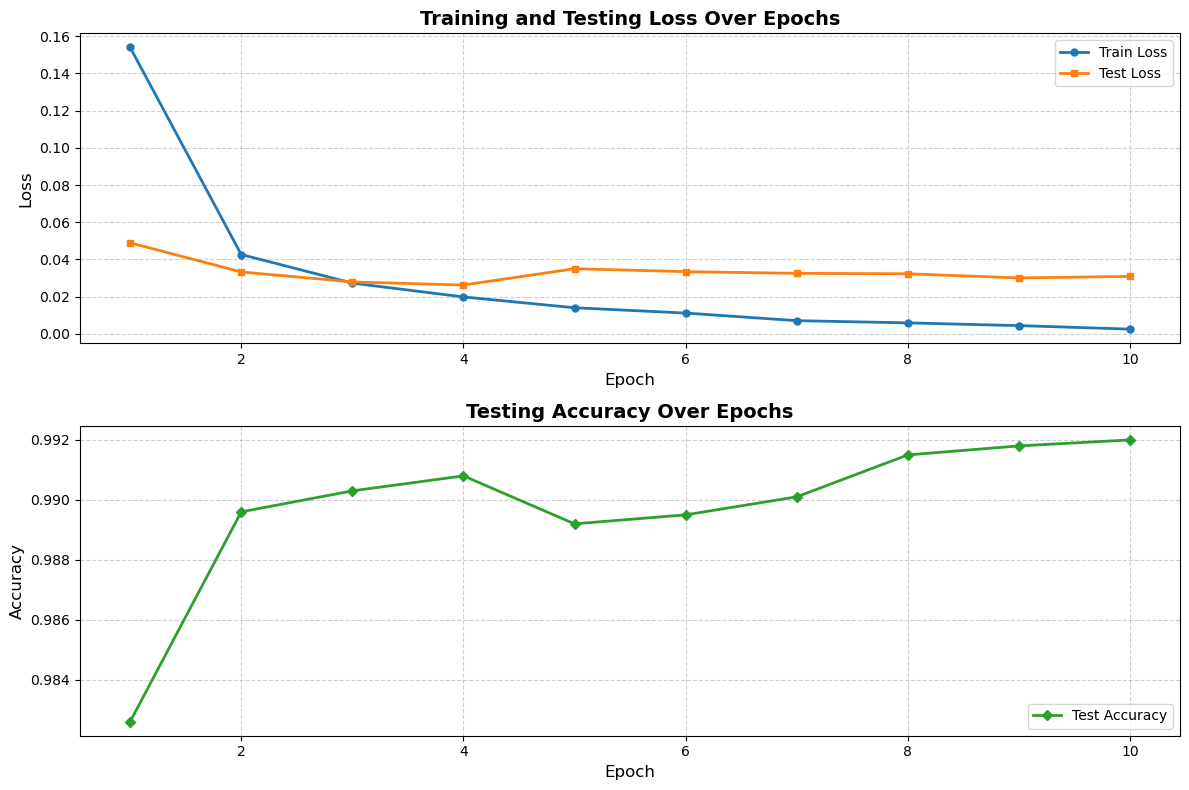

 Total Execution Time: 114.41 seconds
 Total Training Time: 79.74 seconds
 Average Time per Epoch: 7.97 seconds


In [19]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.01, momentum=0.9)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.283659
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.117816

Test set: Average loss: 0.0740, Accuracy: 9767/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.056107
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.146179

Test set: Average loss: 0.0479, Accuracy: 9845/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.051073
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.014187

Test set: Average loss: 0.0349, Accuracy: 9883/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.004696
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.006212

Test set: Average loss: 0.0348, Accuracy: 9885/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.005915
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.044865

Test set: Average loss: 0.0341, Accuracy: 9893/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.007735
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.005026

Test set: Average loss: 0.0352, Accuracy: 9889/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.003333
Train Epoch: 7 [320

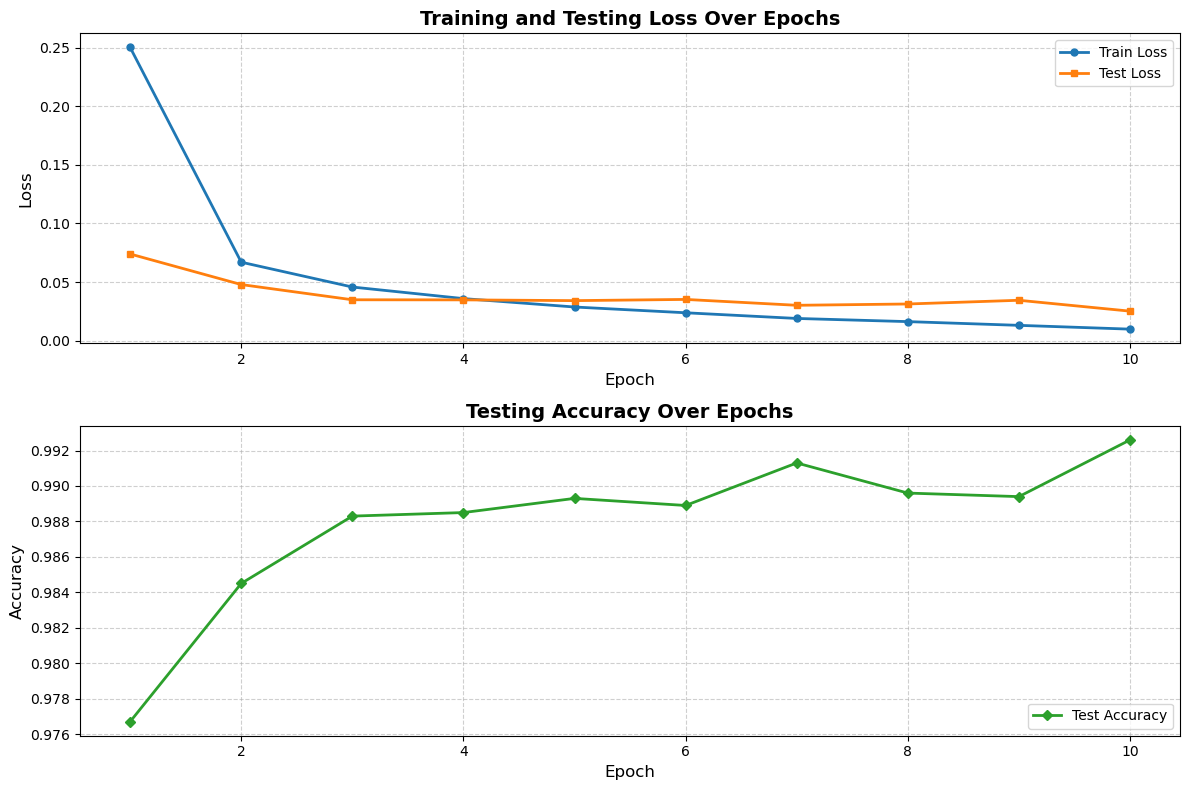

 Total Execution Time: 113.56 seconds
 Total Training Time: 79.13 seconds
 Average Time per Epoch: 7.91 seconds


In [20]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), 0.0001)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

# Changing dimension of batch

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290077
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.298881
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.254704
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.008267
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.002543
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.683389
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.003730
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.002955
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.005727
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.358112
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.002637
Train Epoch: 1 [44000/60000 (73%)]	Loss: 0.015826
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.001792
Train Epoch: 1 [52000/60000 (87%)]	Loss: 0.002982
Train Epoch: 1 [56000/60000 (93%)]	Loss: 0.000919

Test set: Average loss: 0.0518, Accuracy: 9826/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.005343
Train Epoch: 2 [4000/60000 (7%)]	Loss: 0.000606
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.003131
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.066385
Train

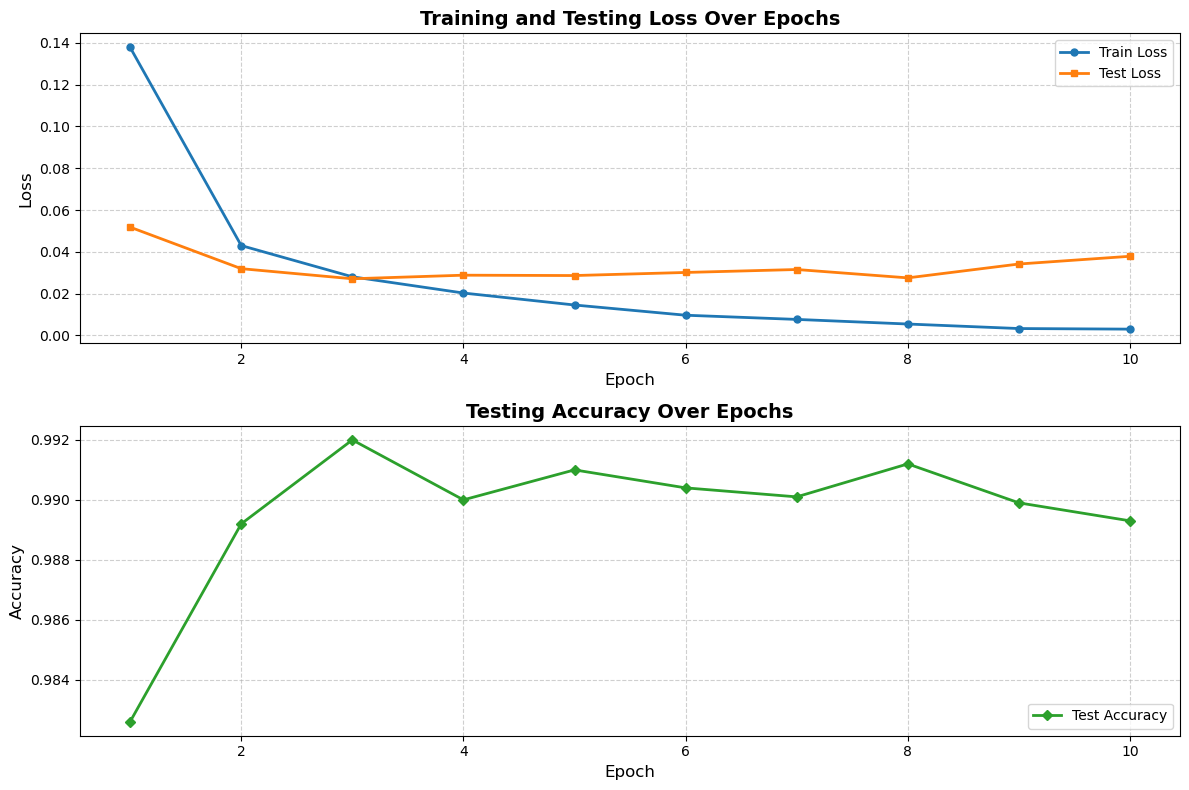

 Total Execution Time: 195.99 seconds
 Total Training Time: 151.94 seconds
 Average Time per Epoch: 15.19 seconds


In [21]:
device = torch.device("cuda") # to use the GPU
batch_size = 8

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
      ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.01)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307527

Test set: Average loss: 0.3302, Accuracy: 9007/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.295884

Test set: Average loss: 0.3264, Accuracy: 9041/10000 (90%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.403889

Test set: Average loss: 0.1585, Accuracy: 9509/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.188240

Test set: Average loss: 0.1345, Accuracy: 9611/10000 (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.172252

Test set: Average loss: 0.0997, Accuracy: 9704/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.104363

Test set: Average loss: 0.0864, Accuracy: 9742/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.086943

Test set: Average loss: 0.0828, Accuracy: 9740/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.103233

Test set: Average loss: 0.0703, Accuracy: 9791/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.030623

Test set: Average loss: 0.0661, Accuracy: 9793/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.118505


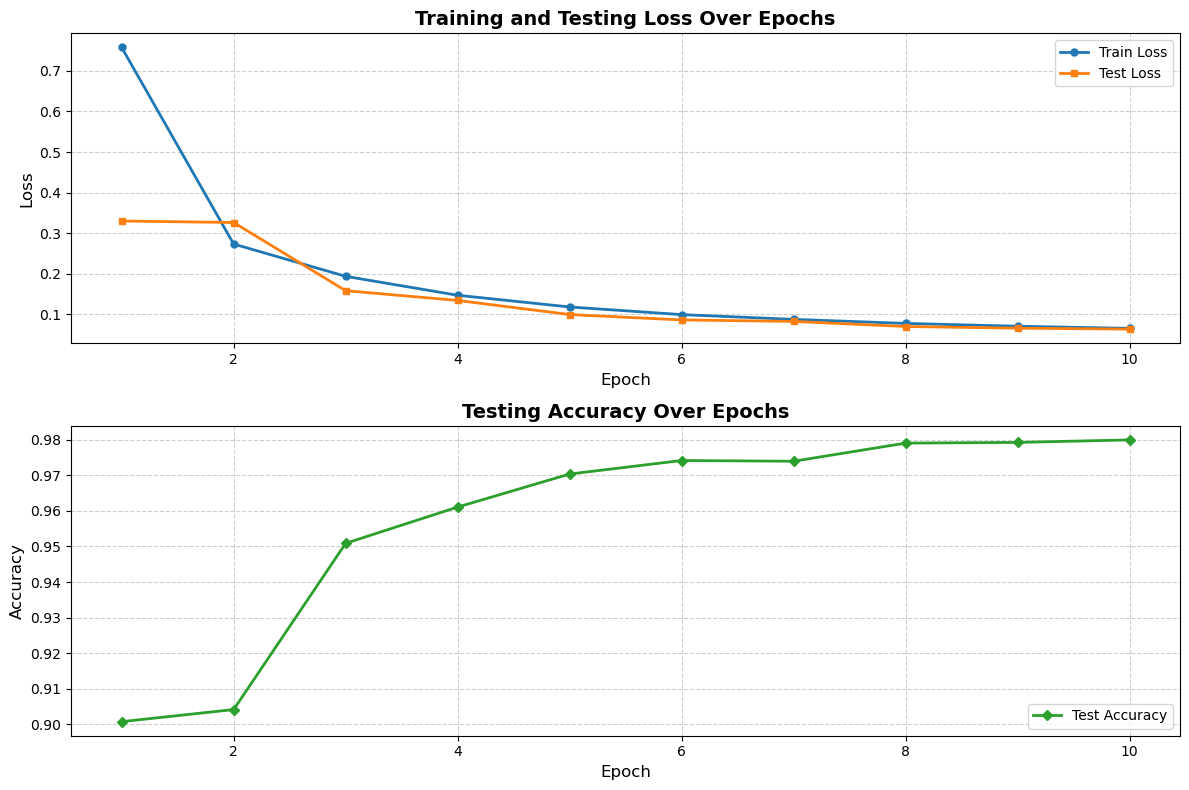

 Total Execution Time: 106.12 seconds
 Total Training Time: 72.55 seconds
 Average Time per Epoch: 7.26 seconds


In [22]:
device = torch.device("cuda") # to use the GPU
batch_size = 64*4

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
      ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, num_workers=1, pin_memory=True,shuffle=True,batch_size=batch_size)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), 0.01)
train_test_plot(model, device, train_loader, test_loader, optimizer, epochs)